In [1]:
import torch
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np
import math
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
from matplotlib.pylab import plt
from torch.distributions.normal import Normal


In [2]:
def sample_xt(zt):
    xt_mode = (zt + xdim / 2).clamp(0, xdim - 1).floor().long()
    xt_params = F.one_hot(xt_mode, num_classes=xdim) * alpha + (1 - alpha) / xdim
    xt_rv = Categorical(xt_params)
    xt_sample = xt_rv.sample()
    xt_onehot_sample = F.one_hot(xt_sample, num_classes = xdim)
    xt_ll = xt_rv.log_prob(xt_sample)
    return xt_sample, xt_onehot_sample, xt_ll


In [3]:
def ROC(y_test, y_prob):
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_prob)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.figure(figsize = (10,10))
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, color = 'red', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1], linestyle = '--')
    plt.axis('tight')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

## 1. True Data Synthesis

$\ Y_i $ ~ $Bernoulli(1/2)$\
$\ Z_{it}|Z_{i,t-1}, Y_i$ ~ $\ N$($0.9 Z_{i,t-1}$,$50.1^{Y_i}$)

In [4]:
#if torch.cuda.is_available():  
#    dev = "cuda:3" 
#else:  
#    dev = "cpu" 
    
#device = torch.device(dev)  

In [5]:
# model parameters
alpha = 0.99

# structural constants
xdim = 100

if __name__ == "__main__":
    # sample z_t ~ Normal(0, 10)
    zt = torch.randn(2000) * 10

    # sample x_t | z_t
    xt_sample, xt_onehot_sample, xt_ll = sample_xt(zt)

    # report the result
    print("Here is a sample of x_t: ", xt_sample)
    print("Here is a onehot sample of x_t: ", xt_onehot_sample)

Here is a sample of x_t:  tensor([62, 52, 36,  ..., 56, 43, 52])
Here is a onehot sample of x_t:  tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


In [6]:
# model parameters
alpha = 0.99

# structural constants
xdim = 100
N = 2000  # number of patients
T = 10  # total time steps

# Yi
success_prob = 0.5
Y = torch.distributions.Bernoulli(success_prob).sample((N,))

# random variables
Omega = torch.tensor((1., 50.1))
Z_true = torch.zeros((N, T)) # latent 
X = torch.zeros((N, T)) # observed
X_onehot = torch.zeros((N, T, xdim))

for t in range(0,T):
    # Zit | Zi,t-1, Yi
    meanz = (0.9 * Z_true[:, t - 1]) if t != 0 else torch.zeros((N,))
    zvar_true = Omega[0] * (1 - Y) + Omega[1] * Y
    Zt = Normal(meanz, zvar_true.sqrt())
    Z_true[:, t] = Zt.sample()
    
    # Xit | Zit
    X[:,t], X_onehot[:, t], x_ll  = sample_xt(Z_true[:, t])


In [7]:
Z_true[:,1].reshape(-1,1).shape

torch.Size([2000, 1])

## 2. Train-Test Split

In [8]:
idx = torch.randperm(N)
train_idx = idx[:math.floor(0.8*N)]
test_idx = idx[math.floor(0.8*N):]
X_train = X_onehot[train_idx,:,:]
X_test = X_onehot[test_idx,:,:]
xd1, xd2, xd3 = X_train.shape
X_train_lr = X_train.view(xd1, xd2*xd3)
xd1, xd2, xd3 = X_test.shape
X_test_lr = X_test.view(xd1, xd2*xd3)

In [9]:
y_train = Y[train_idx]
y_test = Y[test_idx]

## 3. Logistic Regression

In [10]:
lr_accuracy = torch.zeros(T)

clf = LogisticRegression().fit(X_train_lr, y_train)
y_prob_lr = clf.predict_proba(X_test_lr)[:,1]
y_pred_lr = 1*(y_prob_lr > 0.5)

lr_accuracy = accuracy_score(y_test,y_pred_lr)

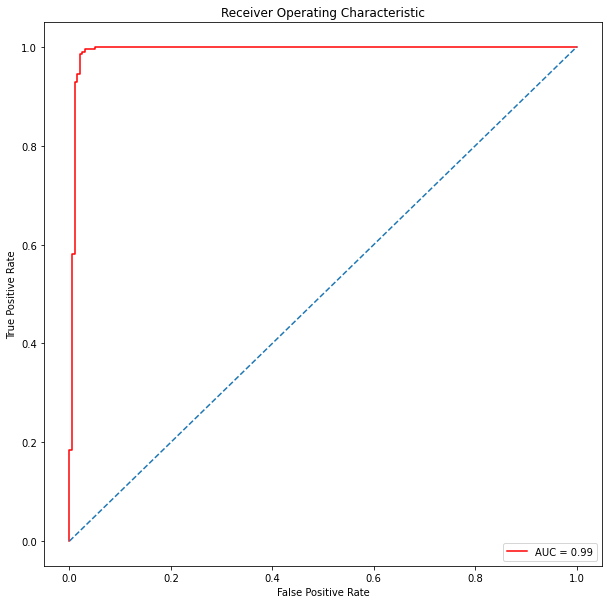

In [11]:
ROC(y_test, y_prob_lr)

## 4. Inference

$\ Z_{it}^{(k)}|Z_{i,t-1}^{(k)}, Y_i$ ~ $\ N$($0.9 Z_{i,t-1}^{(k)}$,$50.1^{Y_i}$)\

$P(X|Y = 1) = E_{P(Z|Y = 1)} [P(X|Z)] \approx \frac{1}{K} \sum_{k=1}^{K} P(X|Z^{(k)}),  Z^{(k)} \sim P(Z^{(k)}|Y = 1)$\
$P(X|Y = 0) = E_{P(Z|Y = 0)} [P(X|Z)] \approx \frac{1}{K} \sum_{k=1}^{K} P(X|Z^{(k)}),  Z^{(k)} \sim P(Z^{(k)}|Y = 0)$

$P(Y = 1 |X) = \frac{P(X|Y = 1)P(Y=1)}{P(X|Y = 1)P(Y=1) + P(X|Y = 0)P(Y=0)}$

In [12]:
K = 1000 # number of simulations

Z = torch.zeros((K, N, T)) 
logPX_Z = torch.zeros((2, K, N, T))

logPX_y = torch.zeros((2, K, N, T))

for t in range(0, T):
    for y in range(2):
        # Zit | Zi,t-1, y
        meanz = (0.9 * Z[:, :, t - 1]) if t != 0 else torch.zeros((K, N))
        var_y = Omega[y]
        Zt = Normal(meanz, var_y.sqrt())
        Z[:, :, t] = Zt.sample()

        # Xit | Zit
        xt_mode = (Z[:, :, t] + xdim / 2).clamp(0, xdim - 1).floor().long()
        xt_params = F.one_hot(xt_mode, num_classes=xdim) * alpha + (1 - alpha) / xdim
        xt_rv = Categorical(xt_params)
        logPX_y[y, :, :, t] = xt_rv.log_prob(X[:, t])

IndentationError: unexpected indent (<ipython-input-12-9b3ddbf531e6>, line 18)

In [ ]:
ElogPX_1k = torch.logsumexp(logPX_y[1], dim = 0) - np.log(K)
ElogPX_1 = torch.mean(ElogPX_1k,dim = 1)

ElogPX_0k = torch.logsumexp(logPX_y[0], dim = 0) - np.log(K)
ElogPX_0 = torch.mean(ElogPX_0k,dim = 1)

In [ ]:
logPX_Y1 = ElogPX_1 + np.log(success_prob)
logPX_Y0 = ElogPX_0 + np.log(1-success_prob)
logPY1_X = logPX_Y1 - (logPX_Y1.exp() + logPX_Y0.exp()).log()
logPY1_X.exp()
Y_pred = 1*(logPY1_X.exp() > 0.5)

In [ ]:
ROC(y_test, logPY1_X.exp()[[test_idx]])

## 5. CNN